# Data Disentangling - Fluorinating Different GNPs

Load the necessary packages and modules.

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import linregress
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

sns.set_theme('paper',font_scale=1.5)
sns.set_style('white')

from modules.disentangling_contributions import \
    create_outline,interpolate_grid_scipy,plot_interpolated_contour,\
        equation_1_Gd_inv,equation_1_Ga_inv,equation_c1,equation_1_Gd,equation_1_Ga,\
        L_a_sim,L_D_sim

## Import Data

Import the .csv from (2)

In [17]:
data_dir = Path.cwd().joinpath('data')
data = pd.read_csv(data_dir.joinpath('input','fluorination_different_gnps_cleaned.csv')).iloc[:,1:]
data['ADGc'] = data['Par_DG_ADG'] * 2.3305**4

## Disentangling Contributions from 0D and 1D Defects

In [18]:
def match_outline(x):
    
    outline_lD = equation_1_Gd_inv(x+(15.0001-x.min()))
    outline_la = equation_1_Ga_inv(x+(15.0001-x.min()))

    outline_lD_len = len(outline_lD)
    outline_la_len = len(outline_la)
    
    generic = np.ones(outline_lD_len) * 500
    
    L_a = np.append(generic,outline_la)
    L_D = np.append(outline_lD,generic)
    line_type = ['dashed'] * outline_lD_len + ['solid'] * outline_lD_len
    
    data            = pd.DataFrame({'LA':L_a,'LD':L_D})
    data['Gd']      = data['LD'].apply(equation_1_Gd)
    data['Ga']      = data['LA'].apply(equation_1_Ga)
    data['y']       = data.apply(lambda x: equation_c1(x.LA,x.LD), axis=1)
    data['type']    = line_type
    
    return data

def envelope_contour(df):
    
    xin = df.columns
    
    outline_match = match_outline(xin)
    
    dashed_columns = outline_match.loc[outline_match['type'] == 'dashed','y'].values
    df.columns = dashed_columns
    df = df.apply(lambda x: x[x.index < x.name] ,axis=0)
    
    solid_columns = outline_match.loc[outline_match['type'] == 'solid','y']
    df.columns = solid_columns 
    df = df.apply(lambda x: x[x.index > x.name] ,axis=0)
    
    df.columns = xin
    
    return df

def translate_points(x,y,df):
    
    xr = round(x,2)
    yr = round(y,2)
        
    lookup = np.nan
    
    if xr in df.columns:
        if yr in df.index:
            lookup = df.loc[yr,xr]

    
    return lookup

In [19]:
xa, ya, za = interpolate_grid_scipy(L_a_sim,'La')
xd, yd, zd = interpolate_grid_scipy(L_D_sim,'Ld')

In [20]:
df_La       = pd.DataFrame(za, index = ya, columns=xa)
df_La_Env   = envelope_contour(df_La)

In [21]:
df_LD       = pd.DataFrame(zd, index = yd, columns=xd)
df_LD_Env   = envelope_contour(df_LD)

In [22]:
df_LD_Env.columns   = np.round(df_LD_Env.columns,2)
df_LD_Env.index     = np.round(df_LD_Env.index,2)
df_La_Env.columns   = np.round(df_La_Env.columns,2)
df_La_Env.index     = np.round(df_La_Env.index,2)

In [23]:
data['La']      = data.apply(lambda g: translate_points(g.Par_G_fwhm,g.ADGc,df_La_Env),axis=1).dropna()
data['LD']      = data.apply(lambda g: translate_points(g.Par_G_fwhm,g.ADGc,df_LD_Env),axis=1).dropna()
data['sigma']   = 1 / (data['LD']**2) 
data['La2']     = (data['La']**2)

In [24]:
data_m = data.groupby(['material','functionalisation'])[['Par_G_fwhm','ADGc','sigma','La2']].agg([np.mean,np.std]).reset_index(drop=False)
data_m.columns = data_m.columns.get_level_values(0)
data_m.columns = [
    'material',
    'functionalisation',
    'Par_G_fwhm_mean',
    'Par_G_fwhm_std',
    'ADGc_fwhm_mean',
    'ADGc_fwhm_std',
    'sigma_mean',
    'sigma_std',
    'La2_mean',
    'La2_std',
    ]
data_m

,material,functionalisation,Par_G_fwhm_mean,Par_G_fwhm_std,ADGc_fwhm_mean,ADGc_fwhm_std,sigma_mean,sigma_std,La2_mean,La2_std
0,C750,BL,60.683726,5.745748,33.506388,4.226669,0.007821,0.005906,122.388872,39.218763
1,C750,CF4,62.413147,7.539348,32.405033,4.485711,0.007402,0.006594,118.670198,38.749254
2,EC-GNP,BL,16.715142,1.430994,0.000000,0.000000,NaN,NaN,NaN,NaN
3,EC-GNP,CF4,18.247196,1.578621,5.189439,3.651605,0.000687,0.000147,6406.318106,2074.411832
4,HP-GNP,BL,19.482449,1.341523,9.498714,1.544415,0.000694,0.000123,4211.066917,1758.335054
5,HP-GNP,CF4,20.420577,1.756878,10.139853,2.199842,0.000821,0.000284,3481.693001,1693.488551
6,PG10,BL,25.734289,3.392814,17.672620,4.673117,0.002007,0.001174,1418.050658,900.261534
7,PG10,CF4,26.102974,3.059498,18.735340,4.547896,0.002317,0.001294,1277.254190,647.535901


In [25]:
data.groupby(['material','functionalisation'])[['Par_D_fwhm','Par_G_fwhm','Par_DG_IDG']].agg([np.mean,np.std])

Par_D_fwhm            Par_G_fwhm            \
                                  mean        std       mean       std   
material functionalisation                                               
C750     BL                 112.879083   9.700495  60.683726  5.745748   
         CF4                110.516958   9.688836  62.413147  7.539348   
EC-GNP   BL                   0.000000   0.000000  16.715142  1.430994   
         CF4                 27.308556  19.092444  18.247196  1.578621   
HP-GNP   BL                  41.444992   2.441039  19.482449  1.341523   
         CF4                 45.802669   3.701777  20.420577  1.756878   
PG10     BL                  61.408031   5.778654  25.734289  3.392814   
         CF4                 59.455715   6.426918  26.102974  3.059498   

                           Par_DG_IDG            
                                 mean       std  
material functionalisation                       
C750     BL                  0.847211  0.091143  
         CF4                 0.841017  0.100620  
EC-GNP   BL                  0.000000  0.000000  
         CF4                 0.077509  0.054627  
HP-GNP   BL                  0.145243  0.026065  
         CF4                 0.147620  0.032763  
PG10     BL                  0.268878  0.097707  
         CF4                 0.288135  0.084438

## Plot

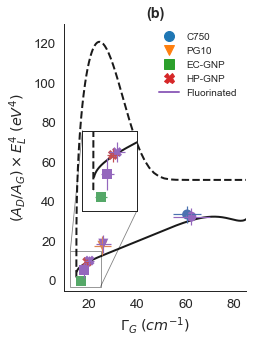

In [26]:
graph = sns.FacetGrid(
    data=data_m,
    hue= 'material',
    hue_order = ['C750','PG10','EC-GNP','HP-GNP'],
    height = 5,
    aspect = 3/4,
    legend_out=False,
)

ax = graph.axes.flatten()[0]    

markers = {'C750':'o',
           'PG10':'v',
           'EC-GNP':'s',
           'HP-GNP':'X'}

def scatter_mapfunc(*args,**kwargs):
    data = kwargs.pop('data')
    filtered_data = data.loc[data['functionalisation']==args[0]]
        
    kwargs['marker'] = markers[kwargs['label']]
    
    if args[1] == False:
        kwargs['color'] = 'tab:purple'
    
    args[2].scatter(filtered_data['Par_G_fwhm_mean'],
                filtered_data['ADGc_fwhm_mean'],
                s =100,
                edgecolors='None',
                **kwargs)

def errorbar_mapfunc(*args,**kwargs):
    data = kwargs.pop('data')
    filtered_data = data.loc[data['functionalisation']==args[0]]
    
    if args[1] == False:
        kwargs['color'] = 'tab:purple'
    
    args[2].errorbar(
        x = filtered_data['Par_G_fwhm_mean'],
        y = filtered_data['ADGc_fwhm_mean'],
        yerr = filtered_data['ADGc_fwhm_std'],
        xerr = filtered_data['Par_G_fwhm_std'],
        **kwargs
        )

graph.map_dataframe(scatter_mapfunc,'BL',True,ax)
graph.map_dataframe(scatter_mapfunc,'CF4',False,ax )
graph.map_dataframe(errorbar_mapfunc,'BL', True, ax)
graph.map_dataframe(errorbar_mapfunc,'CF4', False, ax)
outline_data = create_outline()
graph.set(xlim=(10,85),ylim=(-5,130))
plt.grid(False)
sns.lineplot(data=outline_data.loc[outline_data['type'] == 'dashed'],x='Gd',y='y',ls='--',ax=graph.axes.flatten()[0],color='k',lw=2,zorder=0)
sns.lineplot(data=outline_data.loc[outline_data['type'] == 'solid'], x='Ga',y='y',ax=graph.axes.flatten()[0],color='k',lw=2,zorder=0)

axins = graph.axes.flatten()[0].inset_axes([0.1,0.3,0.3,0.3])
axins.tick_params(labelleft=False, labelbottom=False)
graph.map_dataframe(scatter_mapfunc,'BL',True,axins)
graph.map_dataframe(scatter_mapfunc,'CF4',False,axins)
graph.map_dataframe(errorbar_mapfunc,'BL', True, axins)
graph.map_dataframe(errorbar_mapfunc,'CF4', False, axins)
plt.grid(False)
sns.lineplot(data=outline_data.loc[outline_data['type'] == 'dashed'],x='Gd',y='y',ls='--',ax=axins,color='k',lw=2,zorder=0)
sns.lineplot(data=outline_data.loc[outline_data['type'] == 'solid'], x='Ga',y='y',ax=axins,color='k',lw=2,zorder=0)
axins.get_legend().remove()
axins.set_xlim(12.5,25)
axins.set_ylim(-3,15)
ax.indicate_inset_zoom(axins, edgecolor="black")

custom_lines = [
    Line2D([0], [0], color='tab:blue', lw=0,label='C750',marker='o',markersize = 10),
    Line2D([0], [0], color='tab:orange', lw=0,label = 'PG10',marker='v',markersize = 10),
    Line2D([0], [0], color='tab:green', lw=0,label = 'EC-GNP',marker='s',markersize = 10),
    Line2D([0], [0], color='tab:red', lw=0,label = 'HP-GNP',marker='X',markersize = 10),
    Line2D([0], [0], color='tab:purple', lw=2,label = 'Fluorinated'),
                ]

ax.legend(handles= custom_lines,frameon=False,fontsize=10)
ax.set_xlabel(r'$\Gamma _G$ $(cm^{-1})$')
ax.set_ylabel(r'$(A_D/A_G) \times E_L^4$ $(eV^4)$')
plt.title('(b)',fontweight='bold')
plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 6 (b).png'),dpi=300)
plt.show()

## Feature Correlation

In [27]:
features_in = [
        'Par_D_fwhm',
        'Par_D_amplitude',
        'Par_D_center',
        'Par_D_height',
        
        'Par_G_fwhm',
        'Par_G_amplitude',
        'Par_G_center',
        'Par_G_height',
        
        'Par_D2_fwhm',
        'Par_D2_amplitude', 
        'Par_D2_center',
        'Par_D2_height',         

        'Par_DG_IDG',
        'Par_DG_ADG',
        'Par_D2G_IDG',
        'Par_D2G_ADG',
        'sigma',
        'La2',
        ]

peak_features = {
    'Par_D2_height':'$I_{2D}$',
    'Par_D_height':'$I_{D}$',
    'Par_G_height':'$I_{G}$',
    'Par_DG_ADG':'A$_D$/A$_G$',
    'Par_D2G_ADG':'A$_{2D}$/A$_G$',
    'Par_G_amplitude':'A$_G$',
    'Par_D_amplitude':'A$_D$',
    'La2':'L$_a^2$',
    'Par_G_fwhm': '$\Gamma_G$',
    'Par_G_center':'$\omega_G$',
    'Par_D2_center':'$\omega_{2D}$',
    'Par_D_center':'$\omega_{D}$',
    'Par_D_fwhm':'$\Gamma_D$',
    'Par_D2_fwhm':'$\Gamma_{2D}$',
    'Par_D2_amplitude':'A$_{2D}$',
    'Par_D2G_IDG':'I$_{2D}$/I$_G$',
    'Par_DG_IDG':'I$_{D}$/I$_G$',
    'sigma':'$\sigma$'
}

def prepare_for_spearman(data, func, features_in):
    X = data.loc[data['material']==func][features_in]
    return X

def prepare_correlation_matrix(X):
    corr = spearmanr(X,nan_policy = 'omit').correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    
    return corr

def prepare_distance_matrix(corr):
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    return dist_linkage


def clustering(data, func, features_in):
    X = prepare_for_spearman(data, func, features_in)
    corr = prepare_correlation_matrix(X)
    dist_linkage = prepare_distance_matrix(corr)
    return dist_linkage, X


def select_features(dist_linkage,cutoff,X):
    cluster_ids = hierarchy.fcluster(dist_linkage, cutoff, criterion="distance")
    
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_labelled = X.columns[selected_features]
    
    return selected_features_labelled

def carry_out_heirarchical_clustering(dist_linkage, X, ax,cutoff):
        
    dendro = hierarchy.dendrogram(
        dist_linkage, 
        labels=X.columns.map(peak_features).to_list(), 
        ax=ax, 
        leaf_rotation=90,
        color_threshold=cutoff,
        )   
    
    ax.axhline(cutoff, color = 'k',ls = '--',lw=1)
        
    selected_features = select_features(dist_linkage,cutoff,X)
    print(len(selected_features))
    print(selected_features)

8
Index(['Par_D_fwhm', 'Par_G_fwhm', 'Par_G_amplitude', 'Par_G_center',
       'Par_D2_fwhm', 'Par_D2G_IDG', 'sigma', 'La2'],
      dtype='object')
6
Index(['Par_D_fwhm', 'Par_D_amplitude', 'Par_D_center', 'Par_G_fwhm',
       'Par_G_amplitude', 'Par_D2_amplitude'],
      dtype='object')
8
Index(['Par_D_fwhm', 'Par_D_amplitude', 'Par_D_center', 'Par_G_fwhm',
       'Par_G_center', 'Par_G_height', 'Par_D2_fwhm', 'Par_D2G_IDG'],
      dtype='object')
10
Index(['Par_D_fwhm', 'Par_D_amplitude', 'Par_D_center', 'Par_D_height',
       'Par_G_fwhm', 'Par_G_center', 'Par_G_height', 'Par_D2_fwhm',
       'Par_DG_ADG', 'Par_D2G_IDG'],
      dtype='object')


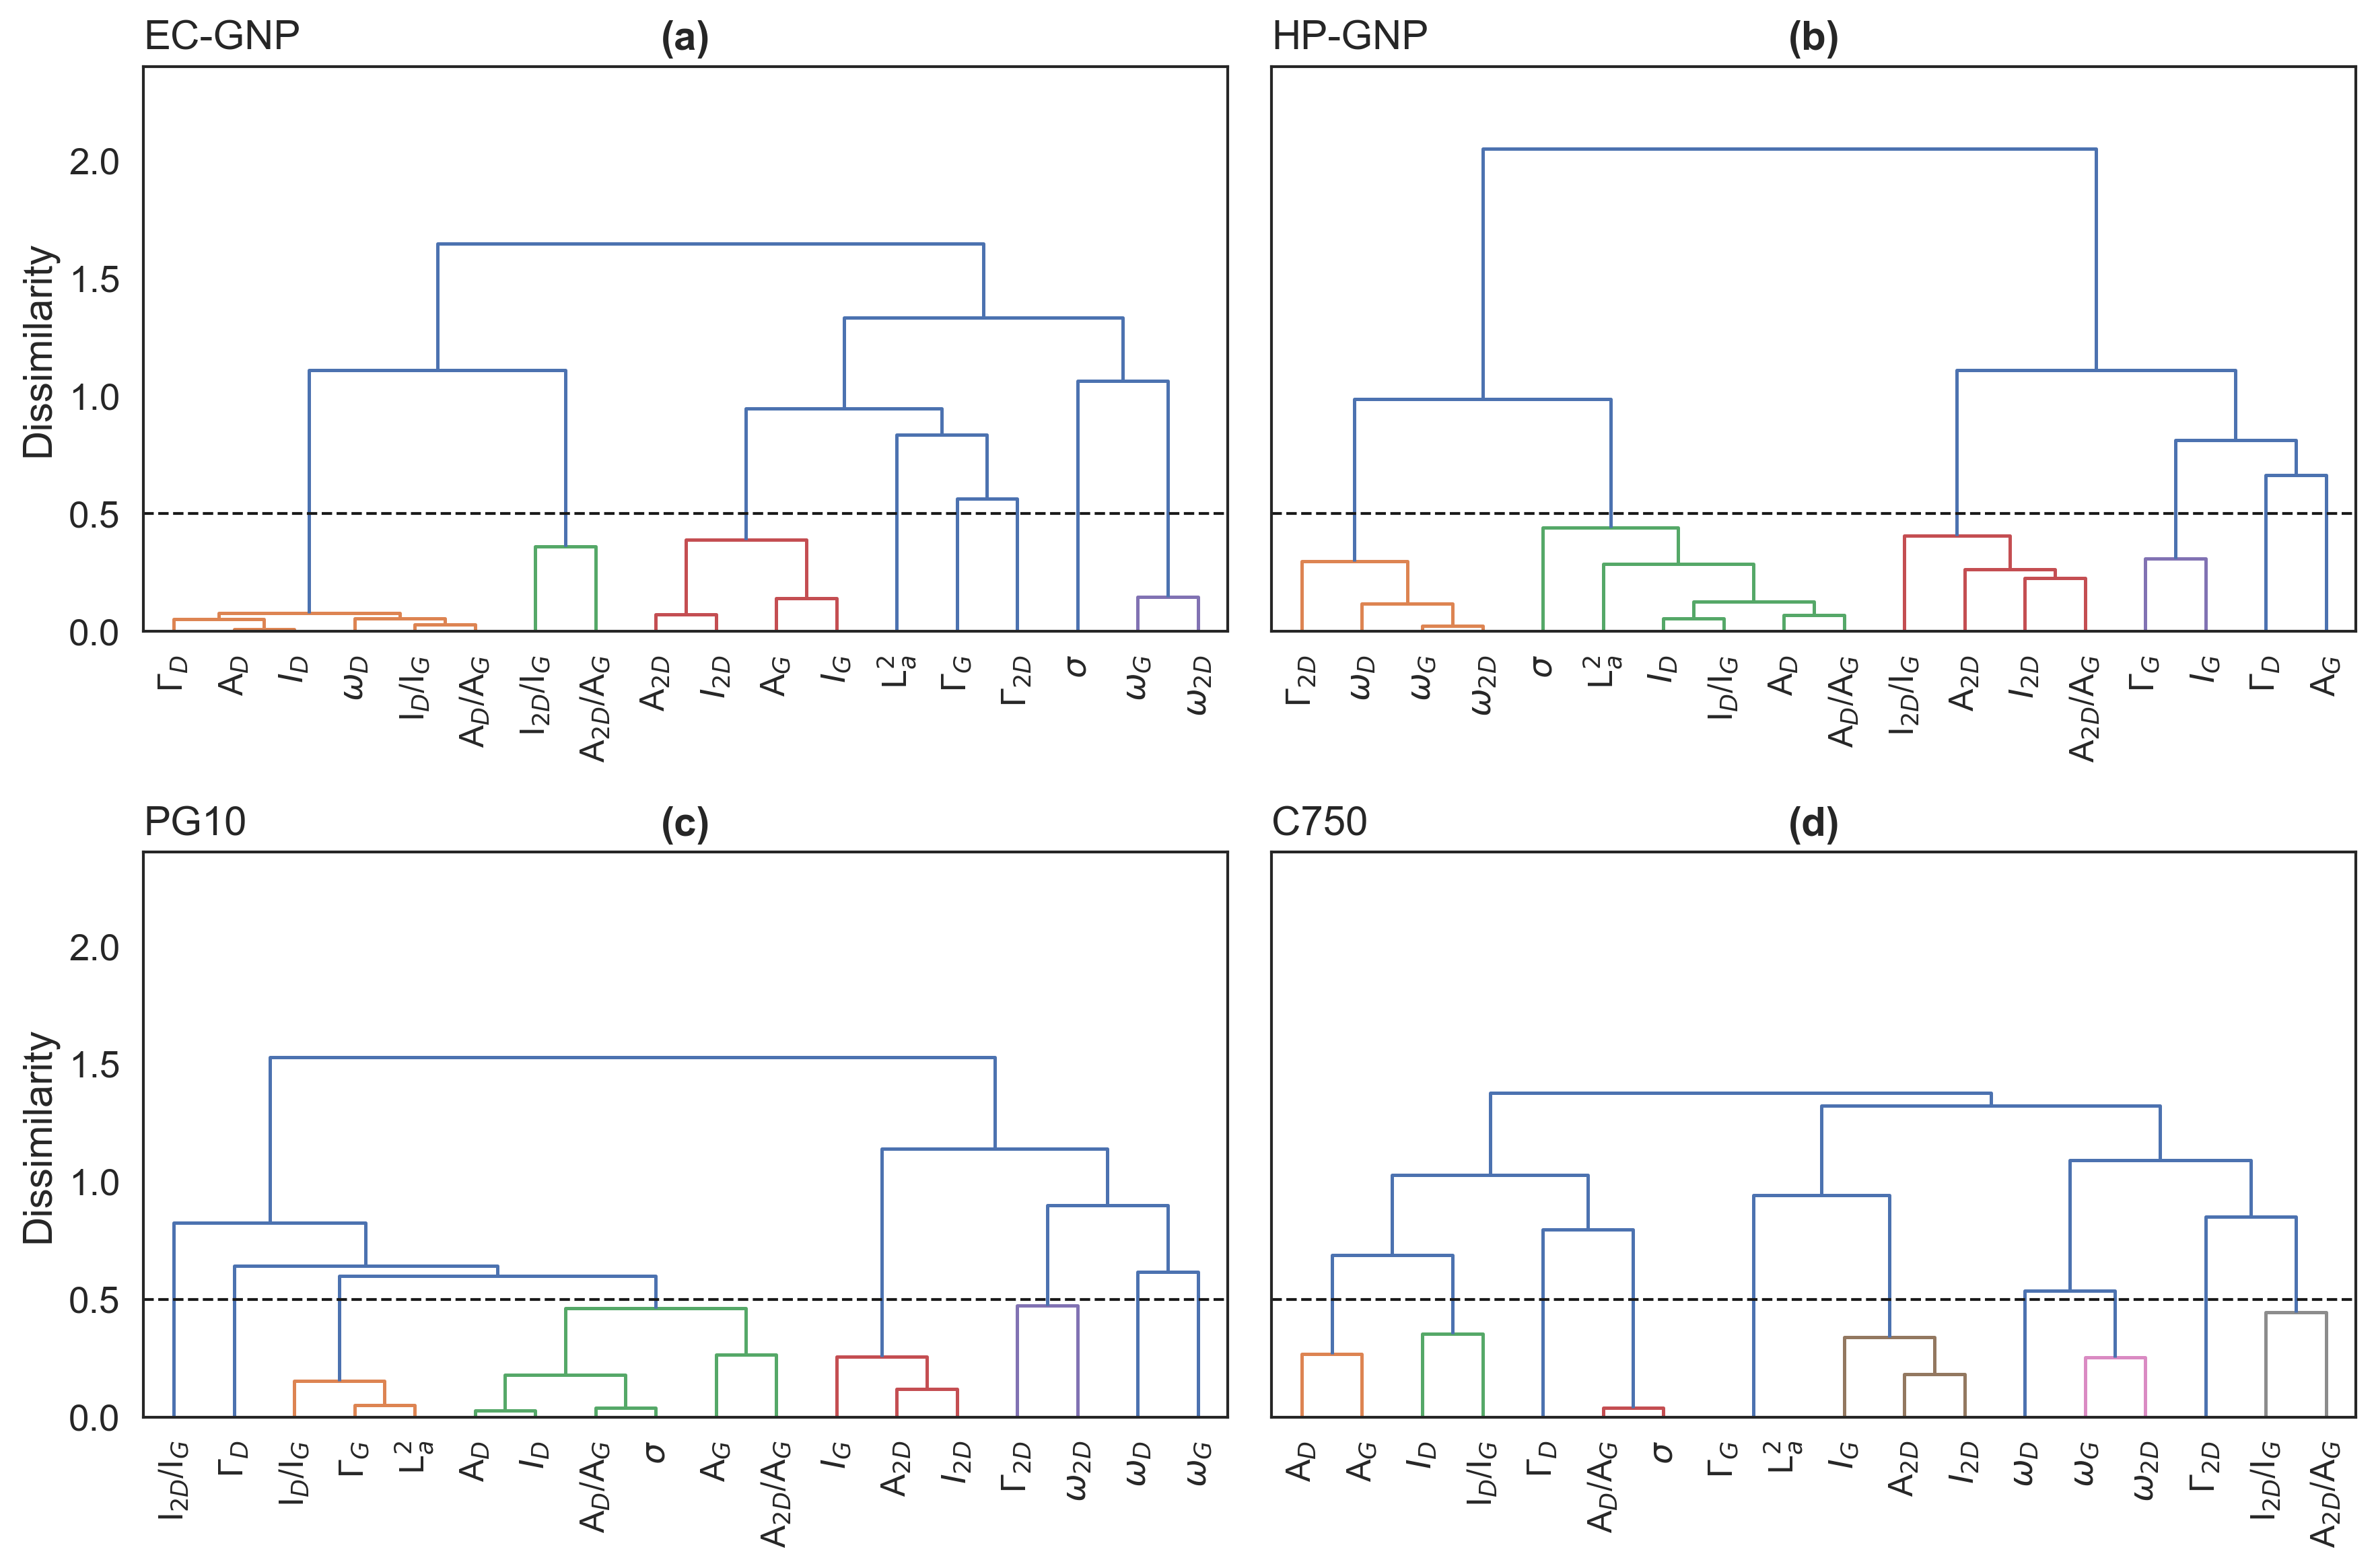

In [28]:

fig,ax = plt.subplots(
    2,2,
    figsize = (12,8),
    dpi = 300,
    sharey=True,
)

dist_linkage, X = clustering(data,'EC-GNP',features_in)
carry_out_heirarchical_clustering(dist_linkage,X,ax[0,0],0.5) 
ax[0,0].set_title('(a)',fontweight='bold')
ax[0,0].set_title('EC-GNP', loc = 'left')
ax[0,0].set_ylim(0,2.4)
ax[0,0].set_ylabel('Dissimilarity')

dist_linkage, X = clustering(data,'HP-GNP',features_in)
carry_out_heirarchical_clustering(dist_linkage,X,ax[0,1],0.5) 
ax[0,1].set_title('(b)',fontweight='bold')
ax[0,1].set_title('HP-GNP', loc = 'left')
ax[0,1].set_ylim(0,2.4)

dist_linkage, X = clustering(data,'PG10',features_in)
carry_out_heirarchical_clustering(dist_linkage,X,ax[1,0],0.5) 
ax[1,0].set_title('(c)',fontweight='bold')
ax[1,0].set_title('PG10', loc = 'left')
ax[1,0].set_ylim(0,2.4)
ax[1,0].set_ylabel('Dissimilarity')

dist_linkage, X = clustering(data,'C750',features_in)
carry_out_heirarchical_clustering(dist_linkage,X,ax[1,1],0.5) #  
ax[1,1].set_title('(d)',fontweight='bold')
ax[1,1].set_title('C750', loc = 'left')
ax[1,1].set_ylim(0,2.4)

for ax in ax.flatten():
    ax.grid('')

plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 7.png'),dpi=300)

## Export Data

In [29]:
data.to_csv(
    Path.cwd().joinpath(
        'data',
        'output',
        'fluorination_different_gnps_disentangled.csv')
)